El análisis exploratorio de los datos es un paso crucial antes de pasar a la generación de modelos de Machine Learning, proporciona el contexto necesario para desarrollar un modelo apropiado e interpretar los resultados correctamente.

## Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Para poder visualizar todas las columnas:
pd.set_option('display.max_columns',100)

# Para ver unicamente 3 decimales:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Acceso a los datos

Se importan los datos que resultaron del proceso de preparación de datos mostrado en la sección anterior:

In [2]:
data = pd.read_csv('C:/Users/gusta/OneDrive/Documentos/Tesis/Datos/Datos_prep.csv') 

## Población analizada

Se comienza analizando el perfil de los alumnos de nuevo ingreso de la FES Iztacala:

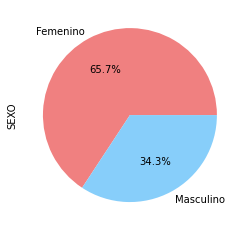

In [3]:
data['SEXO'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                 labels=['Femenino','Masculino'],
                                 colors=['lightcoral','lightskyblue']);

La variable "SEXO" indica el género (Máculino, Femenino) de los alumnos y con base en la gráfica anterior se concluye que la mayoría de los alumnos de nuevo ingreso en la FES Iztacala son mujeres. Dado que no se tiene la cantidad suficiente de datos para tener una muestra balanceada para la variable "SEXO" (50 y 50 de ambos géneros), se decide quitarla del análisis para evitar un sesgo al momento de entrenar los modelos.

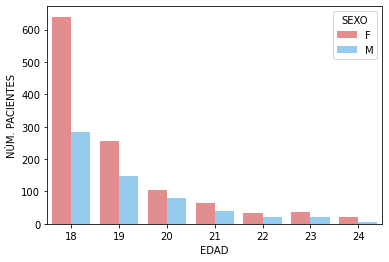

In [4]:
data["CONTEO"] = 1;
sns.barplot(x="EDAD", y="CONTEO", hue="SEXO", data=data, estimator=sum, 
           palette=['lightcoral','lightskyblue']).set_ylabel("NÚM. PACIENTES");

Del gráfico anterior se deduce que la mayoría de los alumnos de nuevo ingreso a la FES Iztacala tienen entre 18 y 19 años de edad, la distribución de esta variable hace sentido con el con lo que se conoce empíricamente de los alumnos de nuevo ingreso a la universidad.

Debido a la cantidad de información con la que se cuenta no sería viable tener una muestra balanceada de observaciones por cada grupo de edad por lo que tampoco será considerada como una variable predictiva.

## Análisis de las variables numéricas

Ahora se hace el cálculo de los principales estadísticos de las variables que contienen las medidas antropométricas de los pacientes y se hace un análisis de la distribución de las mismas:

In [5]:
var_explanatory= [x for x in data.columns if x not in ['ID_EVENTO','SMet','HDL','TRI',
                                                       'TARGET_TRI','TARGET_HDL',
                                                       'CONTEO','EDAD','SEXO']]
data[var_explanatory].describe()

,PAD,PAS,PAM,CC,PESO,TALLA,IMC,CC_AGUA,CC_GRAS,CC_HUES,CC_MUSC,P_AGUA,P_GRAS,P_HUES,P_MUSC,VFA
count,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000
mean,71.783,106.933,83.500,81.360,62.719,162.372,23.707,32.214,18.741,3.049,8.715,51.799,29.288,4.911,14.002,60.008
std,8.727,11.743,8.854,11.194,13.342,8.262,4.237,7.029,8.680,0.626,1.954,7.219,9.766,0.640,1.990,34.406
min,40.000,64.000,48.000,42.500,38.370,137.000,14.889,17.300,1.500,1.470,4.800,33.779,2.703,2.603,9.167,5.000
25%,66.000,100.000,77.333,73.500,52.930,156.000,20.624,26.900,12.600,2.590,7.200,46.562,22.492,4.488,12.564,38.200
50%,70.000,110.000,83.333,80.000,60.400,162.000,22.917,30.400,17.400,2.910,8.200,51.236,30.035,4.936,13.809,56.800
75%,80.000,112.000,90.000,87.500,70.040,168.000,26.203,36.900,23.800,3.420,10.000,56.708,36.353,5.358,15.345,78.300
max,120.000,160.000,127.333,126.000,127.900,188.000,43.415,67.800,65.300,7.060,19.100,74.403,53.931,9.431,20.650,479.600


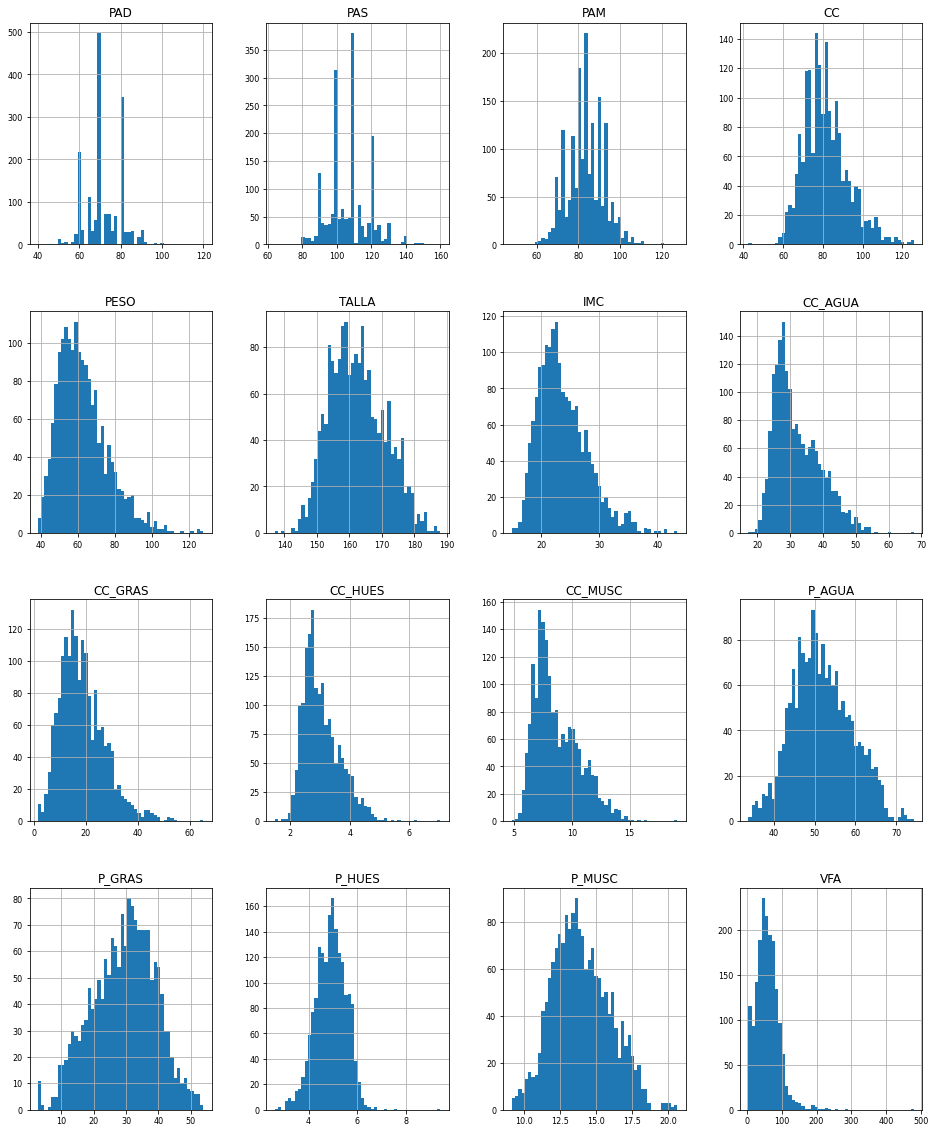

In [6]:
data[var_explanatory].hist(figsize=(16, 20), bins=50, xlabelsize=8, 
                           ylabelsize=8);

Las distribuciones anteriores hacen sentido con los resultados obtenidos en la ENSANUT 2018, en donde se muestra el alto porcentaje de jovenes y adultos con problemas de obesidad y sobrepeso. 

## Selección de variables

Una paso importante antes de comenzar con la construcción de los modelos predictivos es la selección de variables, es decir, la selección de aquellas medidas que ayudarán a explicar el fenómeno a ser modelado. A pesar de que los árboles de decisión no hacen suposiciones sobre las variables de entrada, estos utilizan medidas de impureza (como Gini o Entropía) para identificar los cortes óptimos para mejorar la clasificación, es importante realizar una selección de variables a través del coeficiente de correlación entre las variables para ayudar al modelo proveyéndole de variables que no tengan problemas de multicolinealidad.

### Coeficiente de correlación

 El Coeficiente de Correlación es utilizado en estadística para medir la fuerza y la dirección de la asociación entre dos variables continuas. Hay dos coeficientes de correlación que se usan frecuentemente: el de Pearson (paramétrico) y el de Spearman (no paramétrico, se utiliza en aquellos casos donde las variables examinadas no cumplen criterios de normalidad o cuando las variables son ordinales).

A continuación, se presenta un gráfico que ayuda a identificar la correlación entre las variables numéricas consideradas:

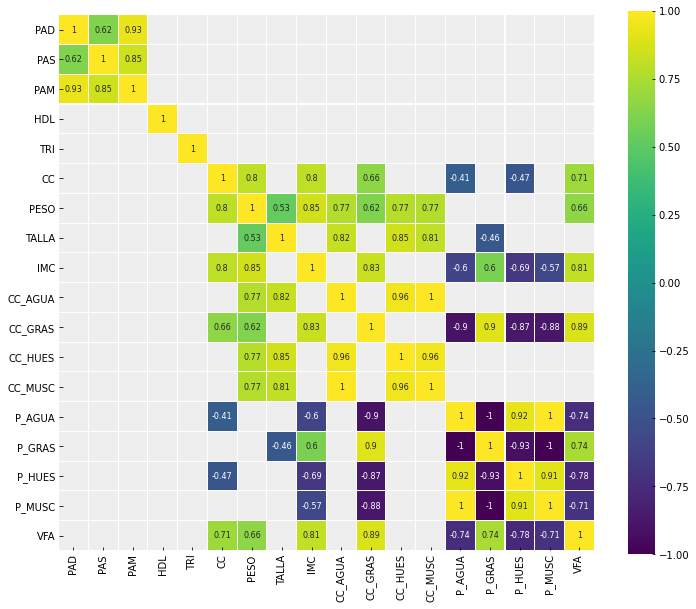

In [7]:
with plt.style.context('bmh'):
    
    corr = data.drop(columns=['ID_EVENTO','SMet','CONTEO',
                              'TARGET_TRI','TARGET_HDL',
                              'EDAD'], axis=1).corr(method='spearman')
    plt.figure(figsize=(12, 10))

    sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, 
                square=True);

plt.show() 

De los coeficientes de correlacion identificados en la gráfica anterior y usando un poco de conocimiento empírico relacionado con el Síndrome Metabólico y, en particular, con los triglicéridos y el colesterol HDL, de deciden utilizar unicamente las siguientes variables: PAM, CC, TALLA, IMC, CC_AGUA, CC_GRAS, CC_MUSC y VFA.